<a href="https://colab.research.google.com/github/ronnieogwang/Self_Driving_car_course/blob/master/section10_behaviorcloning/Behaviorcloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
!git clone https://github.com/ronnieogwang/track_data.git



Cloning into 'track_data'...
remote: Enumerating objects: 17765, done.
remote: Total 17765 (delta 0), reused 0 (delta 0), pack-reused 17765
Receiving objects: 100% (17765/17765), 223.84 MiB | 30.70 MiB/s, done.
Checking out files: 100% (17764/17764), done.


In [179]:
!ls 





driving_log.csv  IMG


In [175]:
!pwd

/content


In [0]:
!pip3 install imgaug

In [178]:
cd track_data


/content/track_data/track_data


In [171]:
!ls

sample_data  Self_Driving_car_course


In [109]:
!ls

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


In [181]:
#get data
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse','speed']
pd.set_option('display.max_colwidth', -1)  
data = pd.read_csv('driving_log.csv', names = columns)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_02_03_16_43_40_221.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_02_03_16_43_40_221.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_02_03_16_43_40_221.jpg,0.0,0.0,0.0,0.000051
1,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_02_03_16_43_40_323.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_02_03_16_43_40_323.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_02_03_16_43_40_323.jpg,0.0,0.0,0.0,0.000050
2,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_02_03_16_43_40_431.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_02_03_16_43_40_431.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_02_03_16_43_40_431.jpg,0.0,0.0,0.0,0.000050
3,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_02_03_16_43_40_537.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_02_03_16_43_40_537.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_02_03_16_43_40_537.jpg,0.0,0.0,0.0,0.000050
4,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\center_2020_02_03_16_43_40_642.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\left_2020_02_03_16_43_40_642.jpg,D:\Machine_Learning\Complete self_drving car course\Self_Driving_car_course\section10_behaviorcloning\Data\IMG\right_2020_02_03_16_43_40_642.jpg,0.0,0.0,0.0,0.000052


In [182]:
#to clear the head from the file names
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2020_02_03_16_43_40_221.jpg,left_2020_02_03_16_43_40_221.jpg,right_2020_02_03_16_43_40_221.jpg,0.0,0.0,0.0,0.000051
1,center_2020_02_03_16_43_40_323.jpg,left_2020_02_03_16_43_40_323.jpg,right_2020_02_03_16_43_40_323.jpg,0.0,0.0,0.0,0.000050
2,center_2020_02_03_16_43_40_431.jpg,left_2020_02_03_16_43_40_431.jpg,right_2020_02_03_16_43_40_431.jpg,0.0,0.0,0.0,0.000050
3,center_2020_02_03_16_43_40_537.jpg,left_2020_02_03_16_43_40_537.jpg,right_2020_02_03_16_43_40_537.jpg,0.0,0.0,0.0,0.000050
4,center_2020_02_03_16_43_40_642.jpg,left_2020_02_03_16_43_40_642.jpg,right_2020_02_03_16_43_40_642.jpg,0.0,0.0,0.0,0.000052


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


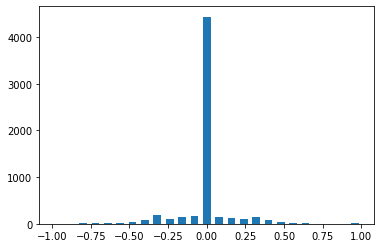

In [183]:
#visualize the steering angle
num_of_bins = 25  #number of classes/ranges of the histogram
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_of_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
print(center)

In [184]:
#remove excess 0 steering angle images
print('total data:', len(data))
remove_list = []
for j in range(num_of_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 5921
removed: 4036
remaining: 1885


In [185]:
#extract data
print(data.iloc[1])
datadir = 'IMG'
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir , data)


center      center_2020_02_03_16_43_42_875.jpg
left        left_2020_02_03_16_43_42_875.jpg  
right       right_2020_02_03_16_43_42_875.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       5.03005e-05                       
Name: 25, dtype: object


In [186]:
#split data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValidation Samples: {}'.format(len(X_train), len(X_val)))


Training Samples: 1508
Validation Samples: 377


Text(0.5, 1.0, 'Validation set')

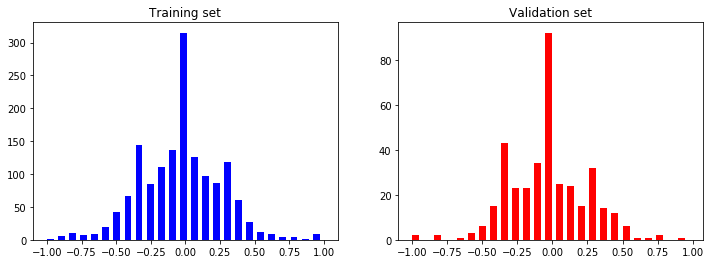

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_val, bins=num_of_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


In [0]:
def zoom(image):
  zoom = iaa.Affine(scale = (1.0, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
#vertical and horizontal translations
def pan(image):
  pan = iaa.Affine(translate_percent= {"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
#brightness
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [0]:
#flipping
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1, 'flipped Imagesteering_angle:-0.04559702')

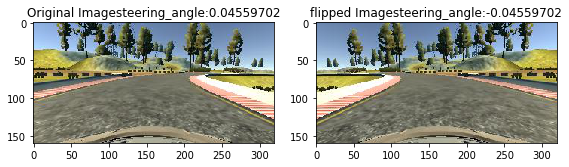

In [192]:
random_index = random.randint(1,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image' + 'steering_angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('flipped Image'  + 'steering_angle:' + str(flipped_steering_angle))

In [0]:
#randomizing the augmentations
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

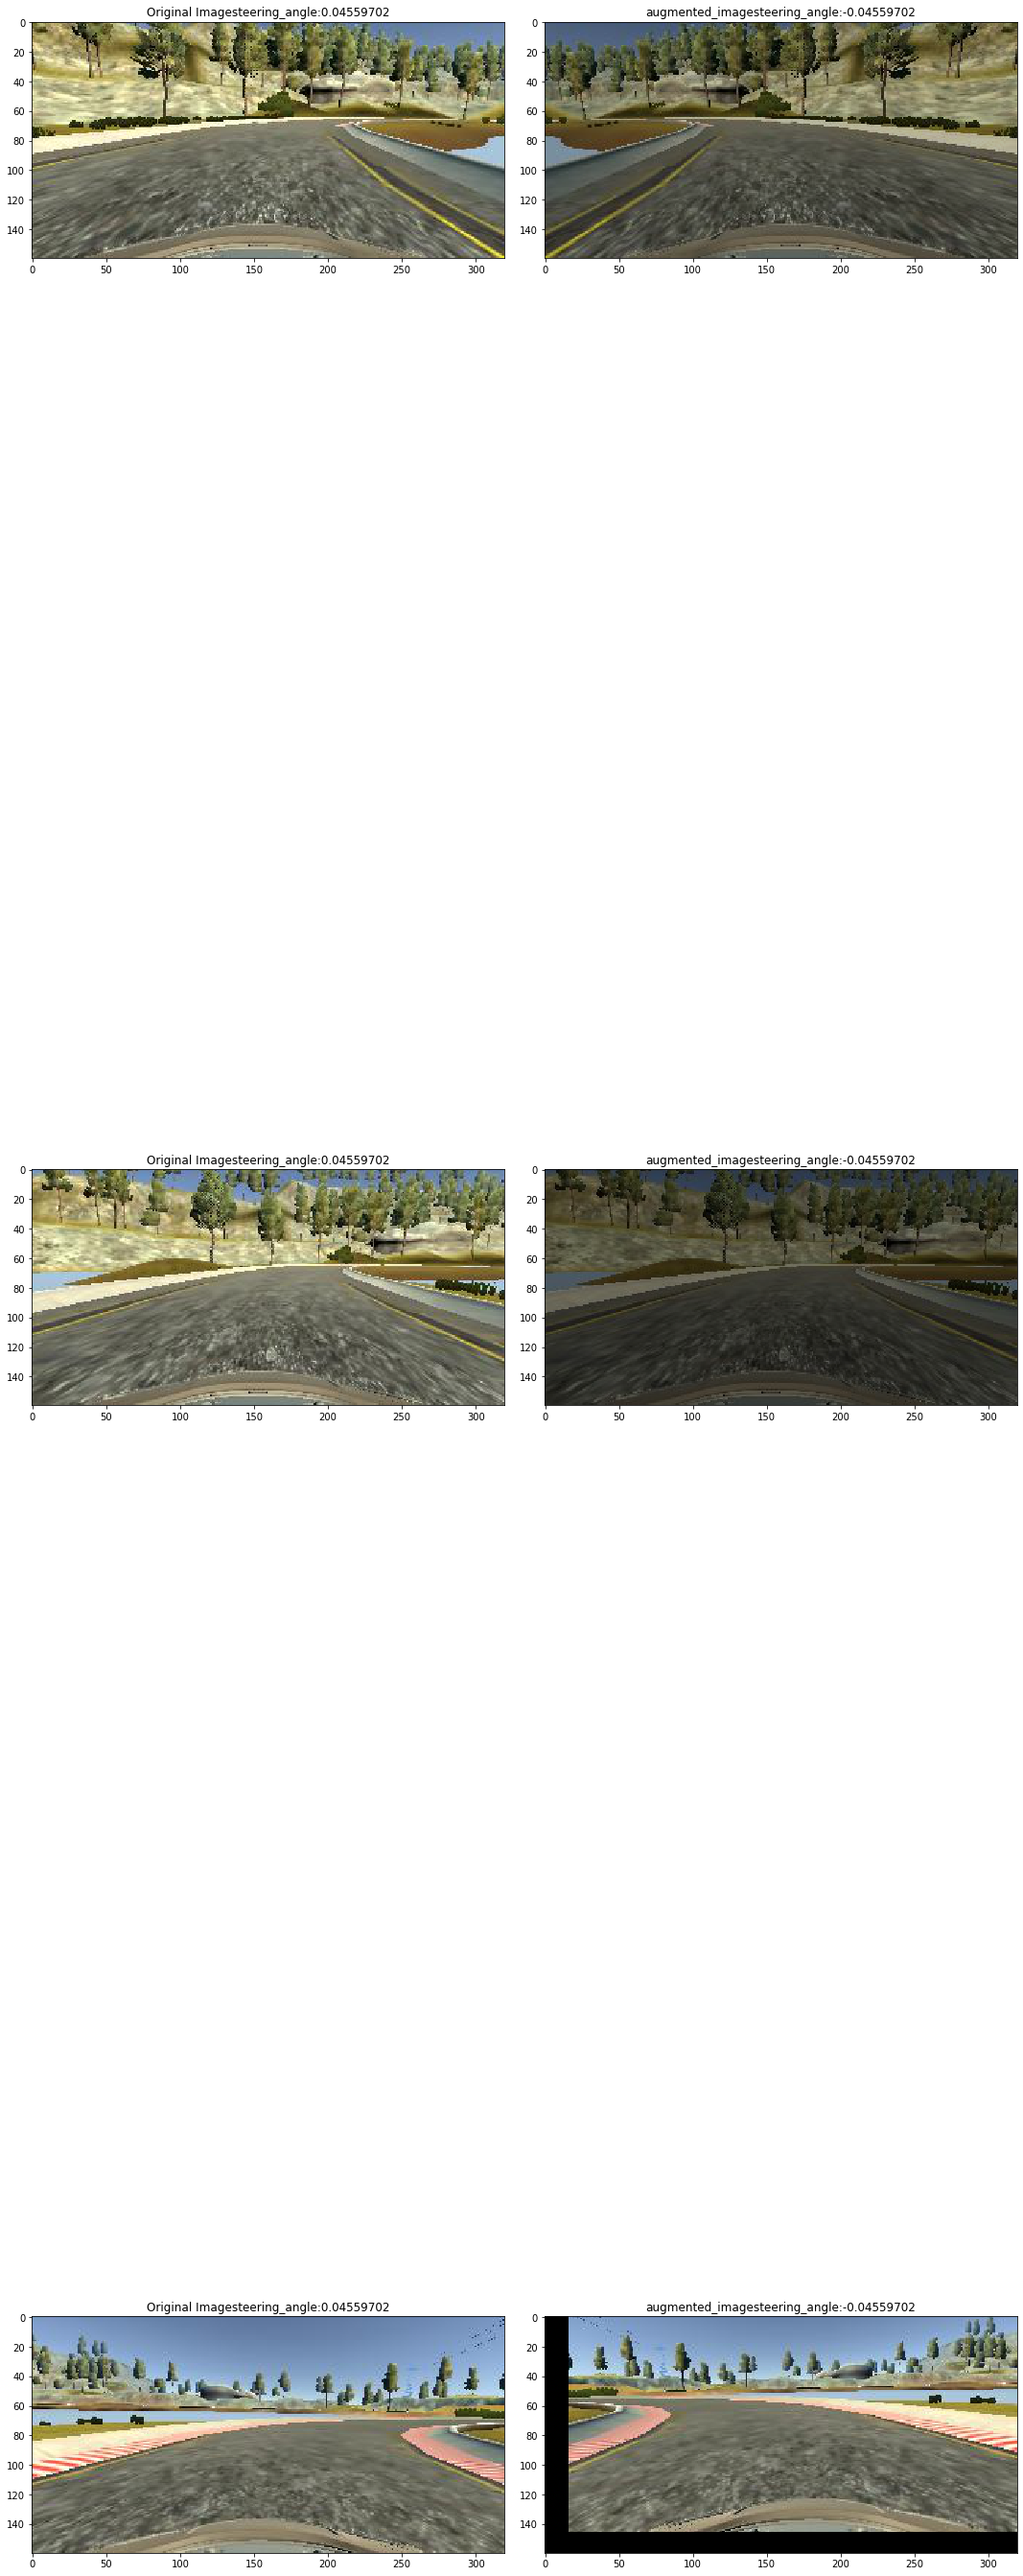

In [194]:
#visualize augmented images
nrows = 3
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 50))
fig.tight_layout()
for i in range(3):
  randnum = random.randint(0, len(image_paths)-1)

  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image' + 'steering_angle:' + str(steering_angle))

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('augmented_image'  + 'steering_angle:' + str(flipped_steering_angle))


In [0]:
#data preprocessing
def img_preprocess(img):
    img = img[60:135, : , :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
#original_image = mpimg.imread(image)
#preprocessed_image = img_preprocess(image)

Text(0.5, 1, 'Preprocessed Image')

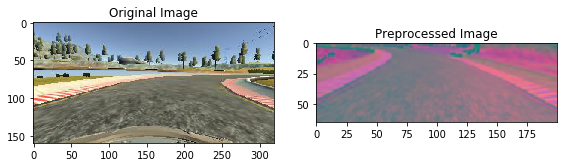

In [196]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
#generates the images at runtime and saves space
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))


# We change the activatiion function fro relu to elu to avoid the dying gradient condition that occurs with relu for negative values. This is seen if the loss is not decreasing

In [203]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample = (2,2), input_shape = (66, 200, 3), activation = 'elu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 3, 3, activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(50, activation = 'elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.compile(Adam(lr = 0.001), loss = 'mse')
    return model
    
model = nvidia_model()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [204]:
h = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_val, y_val, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


Epoch 1/10
300/300 [==============================] - 181s 603ms/step - loss: 0.1197 - val_loss: 0.0721
Epoch 2/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0685 - val_loss: 0.0486
Epoch 3/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0573 - val_loss: 0.0419
Epoch 4/10
300/300 [==============================] - 169s 563ms/step - loss: 0.0522 - val_loss: 0.0405
Epoch 5/10
300/300 [==============================] - 169s 564ms/step - loss: 0.0471 - val_loss: 0.0365
Epoch 6/10
300/300 [==============================] - 168s 559ms/step - loss: 0.0439 - val_loss: 0.0386
Epoch 7/10
300/300 [==============================] - 169s 562ms/step - loss: 0.0414 - val_loss: 0.0390
Epoch 8/10
300/300 [==============================] - 169s 563ms/step - loss: 0.0406 - val_loss: 0.0370
Epoch 9/10
300/300 [==============================] - 169s 563ms/step - loss: 0.0383 - val_loss: 0.0380
Epoch 10/10
300/300 [==============================] - 169s 563m

Text(0.5, 0, 'Epoch')

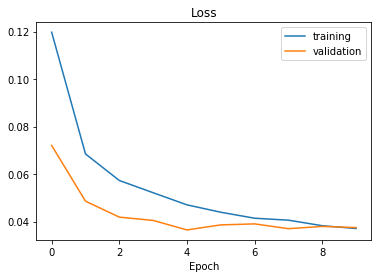

In [205]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')